In [1]:
%matplotlib inline

In [2]:
from fastai.audio import *

In [3]:
sg_cfg= SpectrogramConfig(hop=80, n_mels=80, n_fft=160, top_db=80, f_min=20.0, f_max=22050)
config_split= AudioConfig(resample_to = 8000, remove_silence = "all", silence_padding=200, silence_threshold=20, sg_cfg=sg_cfg, duration=10000, pad_mode='zeros-after')

In [4]:
train_df = pd.read_csv(Path("./data/train.tsv"),sep="\t")

In [5]:
class ImageAudioList(AudioList):
    _bunch = ImageDataBunch
    context = 5
    def reconstruct(self, x): return Image(torch.stack([i[:,self.context+1] for i in x],dim=1).unsqueeze(0))
    
    def show_xys(self, xs, ys)->None:
        items = [[x,y] for i, (x,y) in enumerate(zip(xs,ys))]
        for item in items:
            display(*item)

In [6]:
# class DeepSpeechAudioList(AudioList):
#     _bunch = ImageDataBunch
#     def __init__(self, items, path, config=AudioConfig(), context=5, **kwargs):
#         super().__init__(items=items, path=path, config=config, **kwargs)
#         self.context = context
        
#     def get(self,i):
#         one_spectro = super().get(i).spectro
#         one_spectro = F.pad(one_spectro, pad=(self.context,self.context))
#         return torch.stack([one_spectro[:,:,i:i+(self.context*2+1)].squeeze() for i in range(one_spectro.shape[-1]-(self.context*2))])
    
#     def reconstruct(self, x): return Image(torch.stack([i[:,self.context+1] for i in x],dim=1).unsqueeze(0))
    
#     def show_xys(self, xs, ys)->None:
#         items = [[x,y] for i, (x,y) in enumerate(zip(xs,ys))]
#         for item in items:
#             display(*item)

In [7]:
class SentenceCharList(ItemList):
    
    itoc = list("abcdefghijklmnopqrstuvwxyz '")+['']
    ctoi = defaultdict(lambda: 28)
    def __init__(self, items, path, **kwargs):
        super().__init__(items, **kwargs)
        for i,char in enumerate(self.itoc):
            self.ctoi[char]=i
        
    def get(self,i):
#        return torch.tensor([self.ctoi[j] for j in self.items[i].lower()])
        return F.pad(torch.tensor([self.ctoi[j] for j in self.items[i].lower()]), pad=(0,200), mode='constant', value=28)[:100]
#        return torch.tensor([self.ctoi[j] for j in self.items[i].lower()])

    def reconstruct(self, t:Tensor):
        return "".join((self.itoc[c] for c in t))

In [8]:
#My solution to having to look through training files to make sure they are in training and not validation. 
train_file = defaultdict(bool)
for i in train_df.path:
    train_file[i] = True

In [9]:
def _slice_context(b, context):
    x,y = b
    x = F.pad(x, pad=(context,context))
    x = torch.stack([x[:,:,:,i:i+(context*2+1)] for i in range(x.shape[-1]-(context*2))],dim=2).squeeze()
    return x,y

In [10]:
data = (ImageAudioList.from_folder("data/clips", config=config_split)
        .use_partial_data(0.05, seed=42)
        .filter_by_func(lambda x: train_file[x.name])
        .split_by_rand_pct(0.25, seed=42)
        .label_from_func(lambda x: train_df[train_df.path==str(x).split("/")[-1]]["sentence"].iloc[0], label_cls=SentenceCharList)
        .databunch(bs=4)
        .normalize()
       )

Preprocessing: Resampling to 8000


Preprocessing: Removing Silence


Preprocessing: Resampling to 8000


Preprocessing: Removing Silence


In [11]:
data.add_tfm(partial(_slice_context, context=5))

In [12]:
xb,yb = next(iter(data.train_dl))

In [13]:
xb[0].shape

torch.Size([1000, 80, 11])

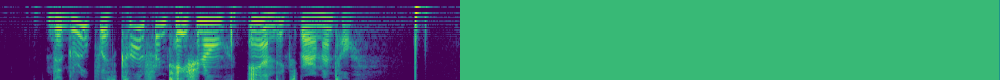

'the group was confrontational and experimental'

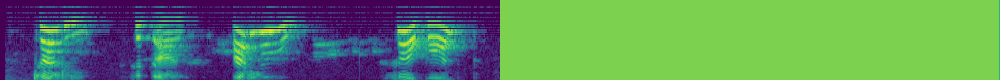

'charley said i are you so cold'

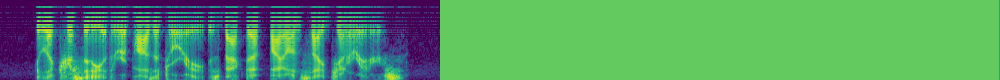

'electricity at the repository is backed up by onsite generators'

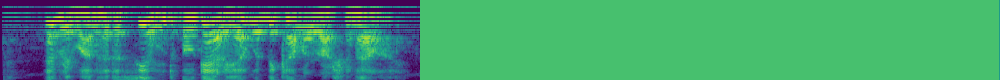

'everyone had assumed bulgaria would become a russian ally'

In [14]:
data.show_batch()

In [15]:
class DeepSpeech(nn.Module):
    def __init__(self, context=5, bs=64):
        super(DeepSpeech, self).__init__()
        self.bs = bs
        self.context = context
        self.flatten = nn.Flatten()#lambda x: torch.reshape(x,(-1,1,2432))
        self.h1 = nn.Linear(80*2*self.context+80,2048)
        self.h2 = nn.Linear(2048,2048)
        self.h3 = nn.Linear(2048,2048)
        self.h4 = nn.LSTM(2048,2048,bidirectional=True,batch_first=True)
        #self.h4 = nn.RNN(2048,2048, nonlinearity="relu",bidirectional=True)
        self.h5 = nn.Linear(2048,29) #ct ∈ {a,b,c, . . . , z, space, apostrophe, blank}
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, x):
        x = x.view(x.shape[0],-1,80*2*self.context+80)
        x = self.h1(x).clamp(min=0, max=20)
        x = self.h2(x).clamp(min=0, max=20)
        x = self.h3(x).clamp(min=0, max=20)
        x,h = self.h4(x)
        x = x.view(-1,1000,2,2048)
        x = x.sum(dim=2)
        x = self.h5(x).clamp(min=0, max=20)
        x = self.softmax(x)
        x = x.permute(1,0,2)
        return x

In [16]:
# def ctc_loss(input, target, bs=64, blank=28):
#     r"""Loss function that makes CTC Loss easier to use especially for putting into a fastai Learner"""
#     i_length = torch.tensor([sum([1 for i in t.sum(1) if i != 0]) for t in input])
#     input = input.permute(1,0,2).detach().requires_grad_()
#     ctc = nn.CTCLoss(blank=blank, zero_infinity=True, reduction="sum")
#     t_length = torch.tensor([sum([1 for i in t if i != blank])for t in target])
#     ret = ctc(input, target, input_lengths=i_length, target_lengths=t_length)#torch.tensor([100]*input.size(1)))
#     return ret

In [17]:
#def calculate_sizes(x):
#    return x.shape[1] - (x.argmax(dim=2) == 28).sum(dim=1) - 1
    
def calculate_sizes(x):
    return x.shape[0] - (x.argmax(dim=2)==28).sum(axis=0)
#     input_lengths = []
#     for input_line in x.argmax(dim=2).flip(1,)==x.argmax(dim=2).flip(1,)[:,0][:,None]:
#         count=0
#         total_length = input_line.shape[0]
#         for elem in input_line:
#             if not elem:
#                 break;
#             count+=1
#         input_lengths.append(total_length-count)
    
#     return torch.tensor(input_lengths)
    
def ctc_loss(log_loss, target, bs=64, blank=28):
    r"""Loss function that makes CTC Loss easier to use especially for putting into a fastai Learner"""
    #i_length = torch.tensor([sum([1 for i in t.sum(1) if i != 0]) for t in input])
    i_length = calculate_sizes(log_loss).long()
    #ctc = nn.CTCLoss(blank=blank, zero_infinity=True, reduction="sum")
    t_length = target.shape[-1]-(target==28).sum(dim=1).long()
    target = target.long()
    #t_length = torch.tensor([sum([1 for i in t if i != blank])for t in target])
    #ret = ctc(log_loss2, target, input_lengths=i_length, target_lengths=t_length)#torch.tensor([100]*input.size(1)))
    ret = F.ctc_loss(log_loss, target, input_lengths=torch.tensor([166]*log_loss.shape[1]), target_lengths=t_length, blank=blank, reduction="sum", zero_infinity=True)
    return ret

In [18]:
model = DeepSpeech(context=data.x.context, bs=data.batch_size)

In [19]:
apply_init(model, nn.init.kaiming_normal_)

In [20]:
learn = Learner(data, model, loss_func=partial(ctc_loss,bs=data.batch_size))

In [21]:
#learn.unfreeze()

In [22]:
xb,yb = next(iter(learn.data.train_dl))

In [23]:
out = model(xb)

In [24]:
out.shape

torch.Size([1000, 4, 29])

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


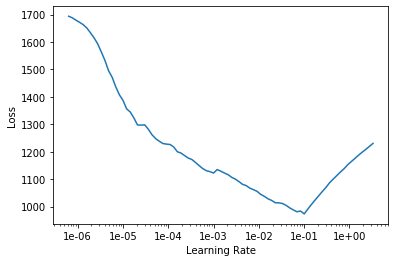

In [26]:
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss,time
0,5800.160645,5551.926270,00:29
1,5357.802734,5040.892090,00:29
2,4909.517578,4577.778809,00:29
3,4551.638184,4251.024902,00:29
4,4126.141113,3994.824951,00:29
5,4426.920898,4332.819824,00:29
6,4165.043457,4031.480469,00:29
7,3887.960205,3920.715332,00:29
8,3648.081787,3863.098145,00:29
9,3540.505371,3847.375977,00:29


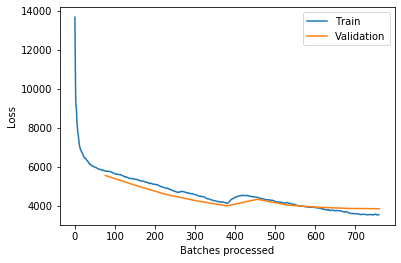

In [26]:
learn.recorder.plot_losses()

In [41]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


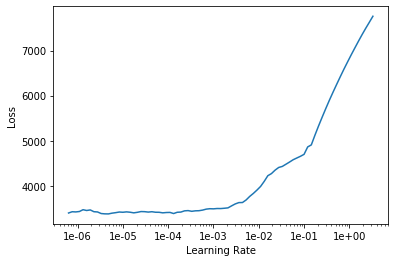

In [42]:
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,time
0,3518.666016,3867.318604,00:29
1,3620.446533,3997.013672,00:29
2,4940.345703,5268.452148,00:29
3,5030.805176,4919.437500,00:29
4,4824.861816,4691.416992,00:29
5,4624.979492,4538.461914,00:29
6,4478.840332,4485.756348,00:29
7,4365.267090,4387.936523,00:29
8,4297.951172,4346.246094,00:29
9,4263.312500,4342.321289,00:29


AttributeError: 'Learner' object has no attribute 'losses'

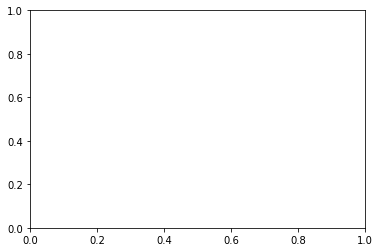

In [51]:
learn.recorder.plot_losses()

In [61]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


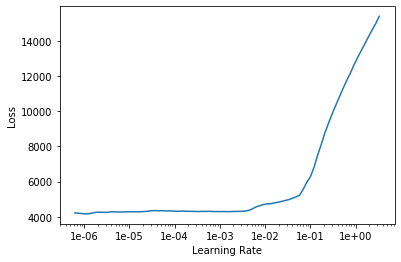

In [62]:
learn.recorder.plot()

In [63]:
learn.fit_one_cycle(10,2e-3)

epoch,train_loss,valid_loss,time
0,4271.493652,4431.310547,00:29
1,4467.761719,4618.634277,00:29
2,4522.267090,4561.311035,00:29
3,4472.578613,4477.621094,00:29
4,4401.739746,4392.833496,00:29
5,4306.020020,4301.886719,00:29
6,4204.113281,4213.490723,00:29
7,4094.977051,4148.164062,00:29
8,3969.635254,4112.631348,00:29
9,3910.353516,4092.246582,00:29


In [64]:
preds,targs = learn.get_preds(n_batch=5)

In [69]:
phrase = 4
print("".join([learn.data.itoc[i] for i in preds.argmax(dim=2)[phrase]]))
print("".join([learn.data.itoc[i]for i in targs[phrase]]))

no
a counter increments the score while the car is moving and on the road


In [56]:
preds.shape

torch.Size([830, 32, 29])

In [57]:
preds.argmax(dim=2)

tensor([[28, 28, 28,  ..., 28, 28, 28],
        [28, 28, 28,  ..., 28, 28, 28],
        [28, 28, 28,  ..., 28, 28, 28],
        ...,
        [28, 28, 28,  ..., 28, 28, 28],
        [28, 28, 28,  ..., 28, 28, 28],
        [28, 28, 28,  ..., 28, 28, 28]])

In [58]:
preds[0].shape

torch.Size([32, 29])

In [60]:
preds[0]

tensor([[-6.6523, -8.0941, -8.0082, -7.1983, -6.6345, -8.3995, -8.1405, -5.6619,
         -6.6274, -8.6567, -8.6567, -6.7143, -7.8060, -7.3138, -7.4692, -8.6567,
         -8.6567, -7.0863, -6.3956, -4.7093, -8.2776, -8.6567, -6.7529, -8.6567,
         -6.9636, -8.6567, -7.4280, -8.6567, -0.0284],
        [-6.6464, -8.2241, -7.5311, -7.2483, -6.6916, -7.9297, -7.9661, -5.5879,
         -6.5058, -8.5397, -8.5397, -7.1549, -7.9618, -7.3524, -7.5165, -8.4331,
         -8.5397, -7.0676, -6.2396, -4.5296, -8.1882, -8.5397, -6.9326, -8.5397,
         -7.2360, -8.5397, -7.2744, -8.5397, -0.0306],
        [-6.6294, -8.0787, -7.6885, -7.2208, -6.5803, -8.1503, -8.0826, -5.4908,
         -6.5694, -8.5339, -8.5339, -6.7302, -7.9440, -7.6128, -7.5844, -8.5339,
         -8.5339, -7.0547, -6.0880, -4.5376, -8.1886, -8.5339, -6.6208, -8.5339,
         -7.0886, -8.5339, -7.2330, -8.5339, -0.0320],
        [-5.6811, -6.2605, -4.2765, -6.0350, -5.5382, -4.2391, -6.1546, -2.8893,
         -4.4111, -6.4459

In [32]:
preds[0][-1][24]

tensor(nan)

In [33]:
preds[0][-1].argmax()

tensor(0)